# Analyzing Agilent chromatograms exported to .cdf format

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import os

# read in anonymized filepath
with open('chrom_path.txt', 'r') as file:
    instrument_path = file.readlines()[0]

# pull all of the .cdf files
chrom_files = []
for file in os.listdir(instrument_path):
    if file.endswith('.cdf'):
        chrom_files.append(file)

chrom_file = chrom_files[0]  # grab one from the list
filepath = os.path.join(instrument_path, chrom_file)

### Check the file's variables

In [2]:
ds = Dataset(filepath, 'r')
for key in ds.variables.keys():
    print(key)

actual_sampling_interval
actual_delay_time
actual_run_time_length
detector_maximum_value
detector_minimum_value
peak_retention_time
peak_name
peak_amount
peak_start_time
peak_end_time
peak_width
peak_area
peak_area_percent
peak_height
peak_height_percent
baseline_start_time
baseline_start_value
baseline_stop_time
baseline_stop_value
peak_start_detection_code
peak_stop_detection_code
retention_index
peak_asymmetry
peak_efficiency
ordinate_values


### Define objects that can structure peak data for us

In [3]:
class Peak:
    """
    Encapsulates individual peak data

    Attributes:
        name (str):              Name of the analyte to which the peak belongs.
        start_time (numeric):    Retention time at which peak integration begins.
        stop_time (numeric):     Retention time at which peak integration ends.
        apex_time (numeric):     Retention time of the peak apex.
        norm_apex (numeric):     Retention time of apex normalized to the retention time of a reference peak.
        height (numeric):        Signal intensity at the apex, or max height of the peak.
    """

    def __init__(self, name, start, stop, area, signal, time):
        """
        Initializes the Peak object.

        Params:
            name (str):           Name of the analyte to which the peak belongs.
            start (numeric):      Retention time at which peak integration begins.
            stop (numeric):       Retention time at which peak integration ends.
            signal (np.ndarray):  Array of detector signal intensities--the chromatogram itself.
            time (np.ndarray):    The time axis of the chromatogram in minutes.
        """
        
        self.name = name
        self.start_time = start  
        self.stop_time = stop    
        self.area = area         
        self.apex_time, self.height = self._get_apex(signal, time)
        self.norm_apex = self.apex_time    

    def _get_apex(self, signal, time):
        """
        Get the retention time and height of the peak apex

        Params:
            signal (np.ndarray):  Array of signal intensities--the chromatogram itself.
            time (np.ndarray):    The time axis of the chromatogram in minutes.
        """

        # find indices in the time array that match the start and stop times.
        # it is necessary to do it this way because elements in the time array may not perfectly line up with any given start/stop time due to 
        # floating point imprecision.  as such, we need to find indices to elements in the time array that most closely approximate 
        # the start/stop times given in the original data file.  
        start_idx = (np.abs(time - self.start_time)).argmin()
        stop_idx = (np.abs(time - self.stop_time)).argmin()
    
        # extract the peak from the raw chromatogram
        peak_sig = signal[start_idx : stop_idx] 
    
        # get the index of the apex
        ret_time_idx = peak_sig.argmax() + start_idx  # offset to where the array slice was taken

        # get the peak height at its apex
        height = signal[ret_time_idx]

        # get the retention time in minutes corresponding to the peak apex
        ret_time = time[ret_time_idx]
    
        return ret_time, height

    def normalize_retention_time(self, ref_peak):
        """
        Normalize the retention time relative to that of a reference peak.  The outcome will be a dimensionless quantity representing
        how far away this peak is from the reference peak.  The idea is to be able to compare chromatograms across instruments and across time,
        where the absolute retention times of various peaks will vary by some amount.

        This function both sets and returns the value of the norm_apex attribute.

        params:
            ref_peak (Peak):  User-defined reference peak.
        """
        
        self.norm_apex = self.apex_time / ref_peak.apex_time

        return self.norm_apex

### Establish peak groups

##### We will do this by iterating over the named peaks and record the retention time at which an uninterrupted series of peaks begins and ends.  If they start back up again, as they do when interspersed with other named peaks, we will assemble those broken intervals into a list.

In [4]:
class Peak_Group:
    """
    Structures peaks into groups as defined by the chromatogram, as opposed to Agilent's method peak grouping per se.

    Attributes:
        name (str):              Name of the group.
        global_start (numeric):  Retention time of the first integration event of the first peak in the group.
        global_stop (numeric):   Retention time of the last integration event of the first peak in the group.
        defs (2D list):          List of start/stop intervals for each section of the group--equal to the global start/stop if the group is continuous.
        norm_defs (2D list):     List of start/stop intervals normalized to a reference peak.
        peaks (list):            List of Peak objects belonging to the group.
    """

    def __init__(self, name, peaks):
        """
        Initializes the Peak_Group object.

        Params:
            name (str):           Filename of chromatogram.
            peaks (list):         List of Peak objects belonging to the group.
        """
        self.name = name
        self.global_start = np.inf
        self.global_stop = 0
        self.defs = []
        self.norm_defs = []
        self.peaks = []

        # TODO: allow initialization with a single peak without wrapping it in a list
        if peaks:
            try:
                self.peaks = [peak for peak in peaks]
            except TypeError:
                raise Exception("Peak_Group objects must be initialized with a list or Numpy array.")

            start, end = self._get_group_def_interval(self.peaks)
            self.global_start = start
            self.global_stop = end
            self.defs.append([start, end])
            
        else:
            self.defs.append([self.global_start, self.global_stop])

    def _get_group_def_interval(self, peaks):
        """
        Get the definition of a particular group interval

        Params:
            peaks (list):         List of Peak objects belonging to the group.
        """
        
        interval_start = np.inf
        interval_end = -1 * np.inf

        for peak in peaks:
            if peak.start_time < interval_start:
                interval_start = peak.start_time
            if peak.stop_time > interval_end:
                interval_end = peak.stop_time

        return interval_start, interval_end     

    def get_major_peak(self):
        """
        Get the major peak of a group

        Params:
            None
        """
        
        major_peak = self.peaks[0]  # initialize with the first peak in the group
        for peak in self.peaks:
            if peak.area > major_peak.area:
                major_peak = peak

        return major_peak

    def add_peaks(self, peaks):
        """
        Update the group with new peaks

        Params:
            peaks (list):         List of Peak objects to be added to the group.
        """

        interval_start, interval_stop = self._get_group_def_interval(peaks)
        
        if self.global_start < interval_start:
            self.global_start = interval_start
        if self.global_stop < interval_stop:
            self.global_stop = interval_stop

        self.peaks += peaks
        self.defs.append([interval_start, interval_stop])

    def normalize_group_def(self, reference_peak):
        """
        Normalize the group definitions by the retention time of a reference peak.

        Params:
            reference_peak (Peak):  User-defined reference peak.
        """

        norm_defs = []
        for start, stop in self.defs:
            norm_start = start / reference_peak.apex_time
            norm_stop = stop / reference_peak.apex_time
            norm_defs.append([norm_start, norm_stop])

        self.norm_defs = norm_defs
        
        return self.norm_defs

### Build a class to parse the NetCDF4 data and handle the chromatogram-level functionality and data

In [5]:
class Chromatogram:
    """
    Encapsulates all the relevant data and calculations for chromatograms read in from NetCDF4 datasets.

    Attributes:
        name (str):             Filename of chromatogram, or other identifier.
        signal (np.ndarray):    Array of signal intensities--the chromatogram itself.
        time (np.ndarray):      The time axis of the chromatogram in minutes.
        peak_names (list):      List of peaks names in the order in which they were integrated.
        peaks (list):           List of Peak objects representing all the integrated peaks.
        reference_peak (Peak):  Peak used for calculating relative retention times (or normalizing retention times).
    """

    def __init__(self, dataset, name):
        """
        Initializes the chromatogram object.

        Params:
            dataset (netCDF4.dataset):  Dataset representing the .cdf file that was originally read in.
            name (str):                 Filename of chromatogram.
        """
        
        # filename for the chromatogram
        self.name = name
        
        # get the data sampling interval (usually 0.02s, but rarely 0.01s)
        interval = dataset.variables['actual_sampling_interval'][:].data
    
        # take the inverse to get the data rate in hertz
        data_hz = 1 / interval

        # pull the raw chromatogram itself
        self.signal = dataset.variables['ordinate_values'][:].data

        # define a time axis in minutes that matches the signal output 
        self.time = np.arange(self.signal.size) / data_hz / 60    # seconds / 50hz (or 100hz) / 60 seconds per minute

        # set peak names
        self.peak_names = self._extract_peak_names(dataset)

        # get start and stop times for each peak
        peak_starts = dataset.variables['peak_start_time'][:].data / 60  # convert from seconds to minutes
        peak_stops = dataset.variables['peak_end_time'][:].data / 60     # convert from seconds to minutes

        # get area counts for each peak
        areas = dataset.variables['peak_area'][:].data
        
        # set the list of peak objects
        self.peaks = self._build_peaks(peak_starts, peak_stops, areas)

        # set the peak groups dictionary
        self.peak_groups = self._build_groups()

        # initialize the reference peak to None
        self.reference_peak = None

    def _extract_peak_names(self, dataset):
        """
        Helper method for decoding peak names stored in binary format.

        Params:
            None
        """
        
        peak_names = []
        for peak in dataset.variables['peak_name'][:].data:
            # peak names are kept in a 2D byte array of shape (peak_number, character_limit).
            # the first dimension associates the peak and the second is an array of byte characters that add to form the name.
            try:
                # decode the ASCII binary and group the character array into a string
                name_string = "".join(character.decode('ASCII') for character in peak[:]) 
            except UnicodeDecodeError:
                # sometimes the peak names are not stored correctly, so we'll default to putting those in the Unnamed category
                name_string = "Unnamed"

            peak_names.append(name_string)
                
        return peak_names

    def _build_peaks(self, starts, stops, areas):
        """
        Build peak objects based on start/stop time arrays and return them as a list.

        Params:
            starts (np.ndarray):  Dataset representing the .cdf file that was originally read in.
            stops (np.ndarray):   Filename of chromatogram.
        """

        peak_list = []
        for idx, name in enumerate(self.peak_names):
            start_time = starts[idx]
            stop_time = stops[idx]
            area = areas[idx]
            peak = Peak(name, start_time, stop_time, area, self.signal, self.time)
            peak_list.append(peak)

        return peak_list

    def _build_groups(self):
        """
        Arrange peaks list into groups and return them as a dictionary.

        Params:
            None
        """

        groups = {}            # dict of peak groups that we'll ultimately return
        contiguous_peaks = []  # list of contiguously grouped peaks in the chromatogram, which will serve as our group intervals
        previous_name = None   # track previous peak name during each loop cycle

        # iterate through each peak name and make decisions about adding them to groups or building new groups
        for name, peak in zip(self.peak_names, self.peaks):
            # unnamed peaks are empty strings, which can cause issues for boolean testing
            if not name:
                name = "Unnamed"
                
            # first iteration case
            if not previous_name:
                previous_name = name
                contiguous_peaks.append(peak)

            # we have encountered a different group and need to add the interval we just collected to the previous group
            elif previous_name != name:
                if previous_name in groups.keys():
                    # add the previous interval to its group
                    groups[previous_name].add_peaks(contiguous_peaks)
                else:
                    # build a group for the previous interval 
                    group = Peak_Group(previous_name, contiguous_peaks)
                    groups[previous_name] = group

                contiguous_peaks = [peak]  # clear out previous list of contiguous peaks and begin with current one
                previous_name = name

            # we are in the middle of an interval
            else:
                contiguous_peaks.append(peak)
                previous_name = name

        # the last interval we built up in the loop needs to be added to a group that may or may not have been built yet
        if previous_name in groups.keys():   # we have build this group already
            groups[previous_name].add_peaks(contiguous_peaks)
        else:                                # we have not built this group yet
            group = Peak_Group(previous_name, contiguous_peaks)
            groups[previous_name] = group
        
        return groups

    def norm_ret_times_by_analyte(self, analyte):
        """
        Normalize the retention times of all peaks in the chromatogram by a user-selected analyte.  The major peak in the analyte's group is
        used as the reference.  

        Params:
            analyte (str):  The name of the analyte by which all retention times will by normalized (must be that of a named peak or group).
        """

        # set reference peak
        self.reference_peak = self.peak_groups[analyte].get_major_peak()

        # set and get normalized retention times for all peaks
        norm_ret_times = []
        for peak in self.peaks:
            time = peak.normalize_retention_time(self.reference_peak)
            norm_ret_times.append(time)

        # set normalized group definitions for all groups
        for group in self.peak_groups.values():
            group.normalize_group_def(self.reference_peak)

        return norm_ret_times

    def plot(self, norm_ret_times=False, labels=True, xmin=0, xmax=None, ymin=0, ymax=None):
        """
        Plot a labeled chromatogram scaled to user specifications

        Params:
            labels (bool):   Toggle peak labels on the plot
            xmin (numeric):  Minimum value on the x-axis of the plot.
            xmax (numeric):  Maximum value on the x-axis of the plot.
            ymin (numeric):  Minimum value on the y-axis of the plot.
            ymax (numeric):  Maximum value on the y-axis of the plot.
        """
        
        # set up chromatogram plot
        fig = plt.Figure(figsize=(4,6))
        ax = plt.subplot()

        # if peaks have been normalized already
        if norm_ret_times and self.reference_peak:
            relative_time = self.time / self.reference_peak.apex_time
            ax.plot(relative_time, self.signal)
            
        # if peaks have not been normalized yet
        elif norm_ret_times and not self.reference_peak:
            raise Exception("Retention times must be normalized before setting norm_ret_times to True.")
            
        # plotting unnormalized peaks
        else:
            ax.plot(self.time, self.signal)

        # set plot parameters
        ax.set_title(self.name, fontsize=8)
        ax.set_xlabel('Minutes')
        ax.set_ylabel('pA')
        ax.set_ybound(lower=ymin, upper=ymax)
        ax.set_xbound(lower=xmin, upper=xmax)

        # add in the peak labels
        if labels:
            for index, peak in enumerate(self.peaks):
                # exclude unlabeled peaks
                if peak.name != "Unnamed":
                    if peak and peak != 'e':  # exclude the solvent peak
                        # set the height of the text label to rise just over the peak itself
                        label_height = peak.height * 1.10 + 15

                        # set rotation angle for the labels, with the default being 45 degrees
                        rotation = 45

                        # plot against relative retention times if needed
                        if norm_ret_times:
                            ret_time = peak.norm_apex
                            time_axis = relative_time
                            ax.set_xlabel('Relative Retention Time')
                        
                        # plot against absolute retention times
                        else:
                            ret_time = peak.apex_time
                            time_axis = self.time

                        # only place labels that are within the zoom window
                        if not xmax:
                            xmax = time_axis.max()
                        if ret_time > xmin and ret_time < xmax:
                            # place the label at the top of the graph if the peak rises past it
                            if ymax and label_height > ymax:
                                label_height = ymax * 0.95  # set the label just under the top
                                rotation = 0               # do not slant the label at the top
                
                            # plot the label text at the tip of the peak
                            ax.text(ret_time, label_height, peak.name, fontsize=8, rotation=rotation)

### Process the chromatogram dataset 

In [22]:
chrom = Chromatogram(ds, chrom_file)

### Plot the chromatogram, zoomed in to a region of interest

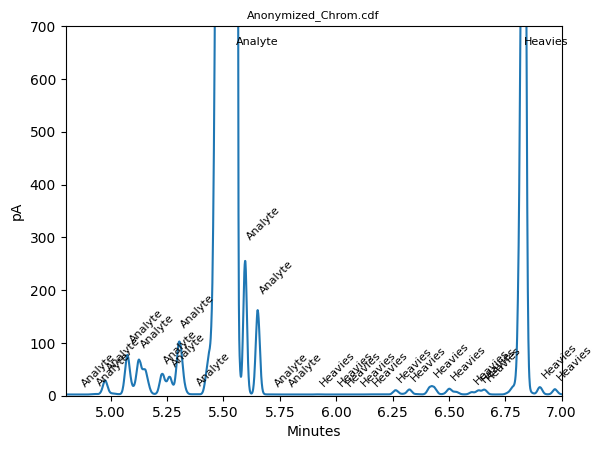

In [7]:
chrom.plot(norm_ret_times=False, labels=True, xmin=4.8, xmax=7, ymax=700)

### Normalize retention times by the main analyte peak and plot the adjusted chromatogram

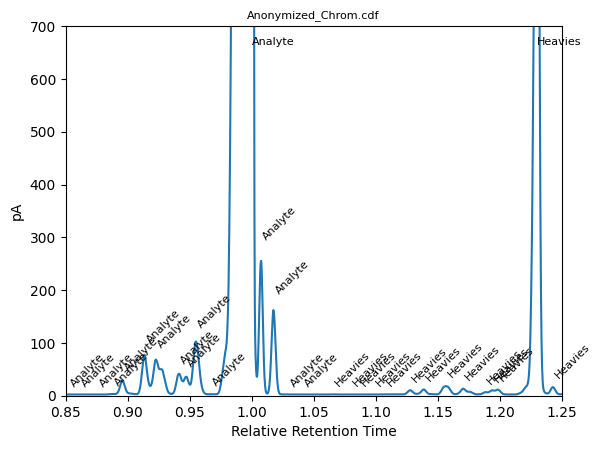

In [8]:
chrom.norm_ret_times_by_analyte('Analyte')
chrom.plot(norm_ret_times=True, labels=True, xmin=0.85, xmax=1.25, ymax=700)